# Финальный проект

## Задание:
<ol>
<li>Изучаете контекст датасета и придумываете бизнес-цель</li>
<li>Делаете постановку задач на исследование (минимум 2 задачи, 1 под классфификацию/регрессию, 1 под кластеризацию (в крайнем случае делаем допущение что у нас нет Y) , )</li>
<li>Оценка Датасета (pandas/np/statsmodel...)</li>
<li>Подготовка данных</li>
<li>Выполнение исследований ( в том числе с промежуточными итогами, визуализациями)</li>
<li>Итоговые визуализации и выводы</li>
<li>Предложения по развитию вашей работы</li>
</ol>

## Кластеризация

<p>Компания производитель одежды из США из среднего ценового сегмента, имеющая сеть магазинов по всей стране, планирует создать новую линейку одежды и хочет определить на какую конкретной группу или группы людей необходимо ориентироваться при ее разработке. Для этого компания хочет провести анализ собственных клиентов. <br><br> Справиться с этой задачей поможет кластерный анализ, который позволит определить основные группы или группу клиентов и подскажет компании, кто является их целевыми клиентами, и на кого стоит ориентироваться при разработке нового продукта, а также если групп несколько, то какая группа клиентов наиболее масштабная.<br><br>
Данные, предоставленные компанией, состоят из информации о более 2000 покупателях из определенной области страны. Все данные были собраны с помощью карт лояльности, которые используются при оформлении заказа. </p>

<p>Основной код для работы с кластеризацией представлен ниже</p>

In [240]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import manhattan_distances
from sklearn.metrics import pairwise_distances #матрица расстояний между объектами (объект-объект)

# Source dataset: https://www.kaggle.com/dev0914sharma/customer-clustering?select=segmentation+data.csv 

PATH_DATA = "../DataForTrainingTasks/segmentation_data.csv"
FEATURES_CUSTOMERS_DICT = {
    0: 'Sex',
    1: 'Marital status',
    2: 'Age',
    3: 'Education',
    4: 'Income',
    5: 'Occupation',
    6: 'Settlement size',
    7: 'Cluster'
}

def load_data(data_path):
    f = os.path.join(str(data_path))
    df = pd.read_csv(f).dropna()
    df.drop_duplicates(subset=['ID'])
    if {'ID'}.issubset(df.columns):
        df.drop(['ID'], axis=1, inplace=True)
    print("\n{0}\n".format(df.head(5)))
    return df

def data_info(data_frame):
    print("{0}\n".format(data_frame.describe()))
    print("Число пустых элементов:\n{0}\n".format(data_frame.isnull().sum()))
    print("Число дубликатов в данных:\n{0}\n".format(data_frame.duplicated().sum()))

def customize_data_for_clustering(data_frame, features, delete_cluster_column = False):
    if (7 in features) and (delete_cluster_column == False) and (FEATURES_CUSTOMERS_DICT[7] in data_frame.columns):
        raise Exception("Data now is clustering")
    elif (7 in features) and (delete_cluster_column == True) and (FEATURES_CUSTOMERS_DICT[7] in data_frame.columns):
        features.remove(7)
        data_frame = data_frame[[FEATURES_CUSTOMERS_DICT[x] for x in features]]
    else:
        if (FEATURES_CUSTOMERS_DICT[7] in data_frame.columns):
            features.append(7)
        data_frame = data_frame[[FEATURES_CUSTOMERS_DICT[x] for x in features]]
    return data_frame

def meanshift_execute(data_frame, bandwidth = 0, max_iter = 300, quantile=0.3):
    data_list = data_frame.values.tolist()
    if bandwidth == 0 or bandwidth < 0:
        if len(data_frame.columns) > 1: 
            bandwidth = estimate_bandwidth(data_list, quantile=quantile)
        else:
            bandwidth = 10 #income вносит основной импакт и немного возраст
    meanshift_clusters = MeanShift(bandwidth = bandwidth, cluster_all=True, max_iter = max_iter).fit(data_list) 
    return meanshift_clusters

def get_distance(clusters_array_one, clusters_array_two):
    euclidean = euclidean_distances(clusters_array_one, clusters_array_two)
    manhattan = manhattan_distances(clusters_array_one, clusters_array_two)
    return euclidean, manhattan

def get_quality_clustering(data_frame, labels):
    return metrics.davies_bouldin_score(data_frame, labels), metrics.calinski_harabasz_score(data_frame, labels), metrics.silhouette_score(data_frame, labels, metric='euclidean')

def get_distance_matrix(data_frame):
    return pairwise_distances(data_frame, metric = 'euclidean')

def clusters_corr(data_frame):
    correl_data = data_frame.corr()
    #print("{0}".format(correl_data))
    fig = plt.figure(figsize=(12, 12), dpi=75)
    ax = fig.add_subplot()
    ax = sns.heatmap(correl_data, annot=True, cmap="PuRd")
    plt.savefig("../DataForTrainingTasks/heatmap.png")  
    plt.show()

def clusters_show(data_frame, features, centers, features_df):
    if len(features) == 2 and len(features_df) >= len(features) and set(features).issubset(set(features_df)) == True:       
        fig = plt.figure(figsize=(12, 12), dpi=75)
        ax = fig.add_subplot()
        ax.scatter(data_frame[FEATURES_CUSTOMERS_DICT[features[0]]], data_frame[FEATURES_CUSTOMERS_DICT[features[1]]], c=data_frame[FEATURES_CUSTOMERS_DICT[7]], s=50, alpha=0.6)
        ax.set_title("{0}/{1}".format(FEATURES_CUSTOMERS_DICT[features[0]], FEATURES_CUSTOMERS_DICT[features[1]]))
        ax.set_xlabel("{0}".format(FEATURES_CUSTOMERS_DICT[features[0]]))
        ax.set_ylabel("{0}".format(FEATURES_CUSTOMERS_DICT[features[1]]))
        # (0, 2) первый кластер и данные по параметру с индексом
        for num in range(len(centers)):
            ax.scatter(centers[num, features_df.index(features[0])], centers[num, features_df.index(features[1])], c='black', s=200, alpha=1) 
        plt.savefig("../DataForTrainingTasks/clusters_2d.png")
        plt.show()
    else:
        raise Exception("Wrong number of features, must be 2 or features_df have not enough number of elements or wrong")

def clusters_show3d(data_frame, features, centers, features_df):
    if len(features) == 3 and len(features_df) >= len(features) and set(features).issubset(set(features_df)) == True:     
        fig = plt.figure(figsize=(12, 12), dpi=75)
        ax = fig.add_subplot(projection='3d')  
        ax.scatter(
            data_frame[FEATURES_CUSTOMERS_DICT[features[0]]], 
            data_frame[FEATURES_CUSTOMERS_DICT[features[1]]], 
            data_frame[FEATURES_CUSTOMERS_DICT[features[2]]], 
            c=data_frame[FEATURES_CUSTOMERS_DICT[7]], s=50, alpha=0.6)
        ax.set_title("{0}/{1}/{2}".format(FEATURES_CUSTOMERS_DICT[features[0]], FEATURES_CUSTOMERS_DICT[features[1]], FEATURES_CUSTOMERS_DICT[features[2]]))
        ax.set_xlabel("{0}".format(FEATURES_CUSTOMERS_DICT[features[0]]))
        ax.set_ylabel("{0}".format(FEATURES_CUSTOMERS_DICT[features[1]]))
        ax.set_zlabel("{0}".format(FEATURES_CUSTOMERS_DICT[features[2]]))
        for num in range(len(centers)):
            ax.scatter(centers[num, features_df.index(features[0])], centers[num, features_df.index(features[1])], centers[num, features_df.index(features[2])], c='black', s=200, alpha=1) 
        plt.show()
    else:
        raise Exception("Wrong number of features, must be 3 or features_df have not enough number of elements or wrong")

df = load_data(PATH_DATA)



   Sex  Marital status  Age  Education  Income  Occupation  Settlement size
0    0               0   67          2  124670           1                2
1    1               1   22          1  150773           1                2
2    0               0   49          1   89210           0                0
3    0               0   45          1  171565           1                1
4    0               0   53          1  149031           1                1



<p>Что известно о самих признаках?</p>
- Sex (пол клиента) <br>
- Martial status (семейный статус) <br>
- Age (возраст) <br>
- Education (уровень образования) <br>
- Income (годовой доход) <br>
- Occupation (род деятельности) <br>
- Settlement size (размер населенного пункта) <br>
<p>При этом стоит отметить, что все данные закодированы и представлены числами, следовательно дополнительных манипуляций производить не нужно.</p>

<p>Первым шагом необходимо проверить информацию о данных.</p>

In [241]:
data_info(df)

               Sex  Marital status          Age   Education         Income  \
count  2000.000000     2000.000000  2000.000000  2000.00000    2000.000000   
mean      0.457000        0.496500    35.909000     1.03800  120954.419000   
std       0.498272        0.500113    11.719402     0.59978   38108.824679   
min       0.000000        0.000000    18.000000     0.00000   35832.000000   
25%       0.000000        0.000000    27.000000     1.00000   97663.250000   
50%       0.000000        0.000000    33.000000     1.00000  115548.500000   
75%       1.000000        1.000000    42.000000     1.00000  138072.250000   
max       1.000000        1.000000    76.000000     3.00000  309364.000000   

        Occupation  Settlement size  
count  2000.000000      2000.000000  
mean      0.810500         0.739000  
std       0.638587         0.812533  
min       0.000000         0.000000  
25%       0.000000         0.000000  
50%       1.000000         1.000000  
75%       1.000000         1.00

<p>Как видно в данных отсуствуют дубликаты и пустые значения в строчках, что говорит о том, что данные хорошего качества. Из всех признаков сильно выделяются Age и Income, их диапазоны существенно отличаются от всех остальных. <br> В обычном случае стоило бы провести масштабирование данных, а точнее нормализацию или стандартизацию, но особенностью используемого алгоритма является то, что он не определяет кластеры на плоской геометрии, говоря иначе, если провести нормализацию или стандартизацию, то все объекты для данного алгоритма становятся элементами одного кластера. В связи с этим решено не проводить масштабирование данных. <br> Однако положительной стороной алгоритма, как и его скоростью работы, является то, что он сам определяет число кластеров и единственной важной для него характеристикой является bandwidth, или упрощенно - радиус, в который попадают ближашие соседи при проверке каждого объекта.</p>

<p>Проверим теперь корреляцию признаков, в случае если значения будут выше 0.7, то произведем удаление признаков.</p>

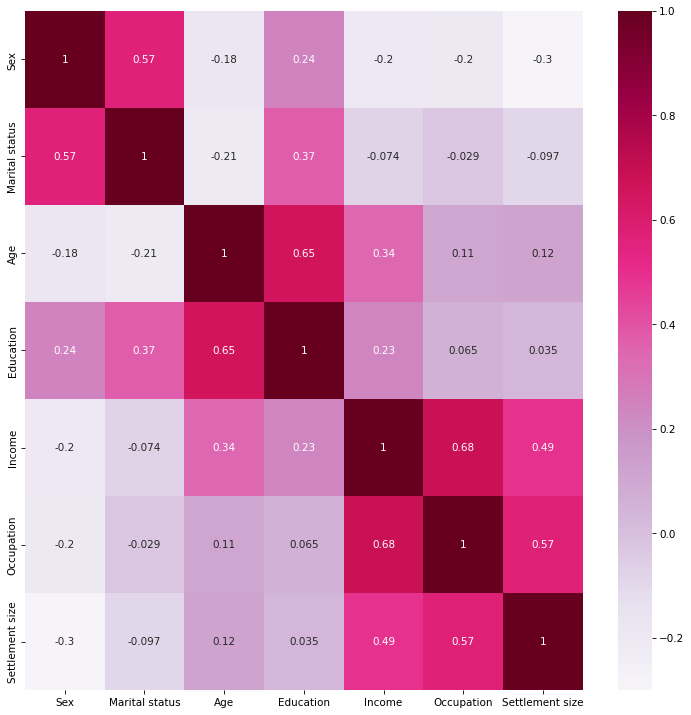

In [242]:
clusters_corr(df)

<p>В данном случае, как видно по графику данные коллерируют в пределах ограничения, следовательно их влияние на интерпретацию или качество модели не так велико, по этой причине все признаки остаются для проведения кластеризации.</p>

<p>Рассмотрим распределение данных. Алгоритм кластеризации чувствителен к типу геометрии, если бы кластеры располагались явно отдельно или можно было бы выбрать число кластеров, как в k-means, то проблем с кластеризацией не было бы при использовании алгоритма. Поэтому важной особенностью хороших данных для выбранного алгоритма является более выраженная концентрация объектов в нескольких группах (кластерах) слабо связанных между собой, и менее выраженное нормальное распределение, тогда для алгоритма не составит труда определить кластеры. В случае нормального распределения и наличия ярко выраженной связи между кластерами, на всех признаках, объекты могут концентрироваться близко к друг другу и создавать тем самым плоскую геометрию.</p>

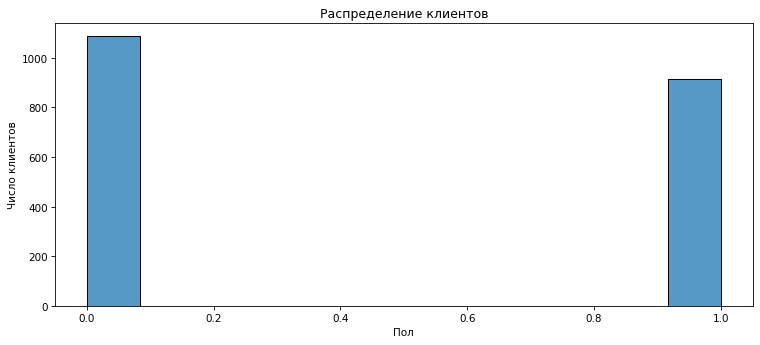

In [243]:
fig = plt.figure(figsize=(12,5), dpi=75)
ax = fig.add_subplot()
ax = sns.histplot(df["Sex"])
ax.set_title("Распределение клиентов")
ax.set_xlabel("Пол")
ax.set_ylabel("Число клиентов")
plt.show()

<p>На данном графике представлены клиенты распределенные по полу, 0 = мужчины, 1 - женщины, при этом как видно мужчин больше. Распределение явно не является нормальным, что указывает на создание двух отдельных групп без связи.</p>

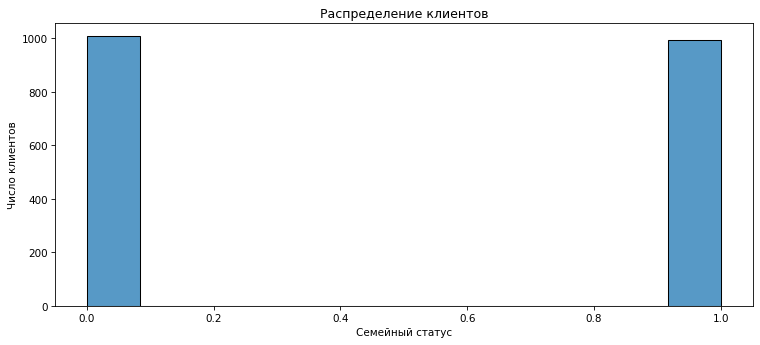

In [244]:
fig = plt.figure(figsize=(12,5), dpi=75)
ax = fig.add_subplot()
ax = sns.histplot(df["Marital status"])
ax.set_title("Распределение клиентов")
ax.set_xlabel("Семейный статус")
ax.set_ylabel("Число клиентов")
plt.show()

<p>Здесь представлено распределение по семейному статусу, где 0 - холост, 1 - женатый (замужем), в разводе и т.д. клиент. При этом их примерно равное количество. Распределение также не является нормальным и кластеры сильно отдалены друг от друга. Следовательно, этот признак не участвует в формировании плоской геометрии, как и предыдущий.</p>

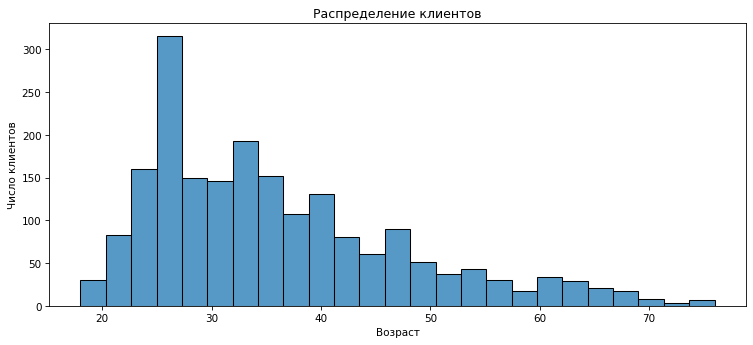

In [245]:
fig = plt.figure(figsize=(12,5), dpi=75)
ax = fig.add_subplot()
ax = sns.histplot(df["Age"])
ax.set_title("Распределение клиентов")
ax.set_xlabel("Возраст")
ax.set_ylabel("Число клиентов")
plt.show()

<p>Здесь представлено распределение по возрасту, как видно на данных для возраста распределение стремится к нормальному, но таковым 100%  не является. Также стоит отметить, что это один из признаков, который в дальнейшем будет вносить большое, но не наибольшее, влияние на результаты кластеризации.<br> Также стоит отметить, что основная часть клиентов компании прозводителя одежды сконцентрирована в области 20-40 лет, еще часть в области 40-50 лет.</p>

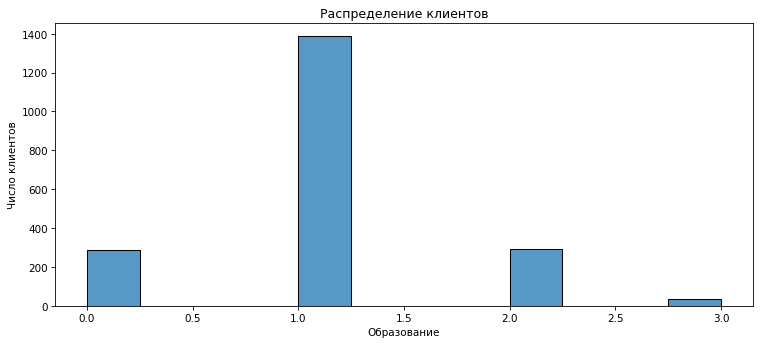

In [246]:
fig = plt.figure(figsize=(12,5), dpi=75)
ax = fig.add_subplot()
ax = sns.histplot(df["Education"])
ax.set_title("Распределение клиентов")
ax.set_xlabel("Образование")
ax.set_ylabel("Число клиентов")
plt.show()

<p>Здесь представлено распределение по уровню образования, где 0 - неизвестен, 1 - средняя школа, 2 - университет, 3 - высшая школа (аспирантура и т.д.). Большая часть клиентов закончили только среднюю школу (11 класс включительно).</p>

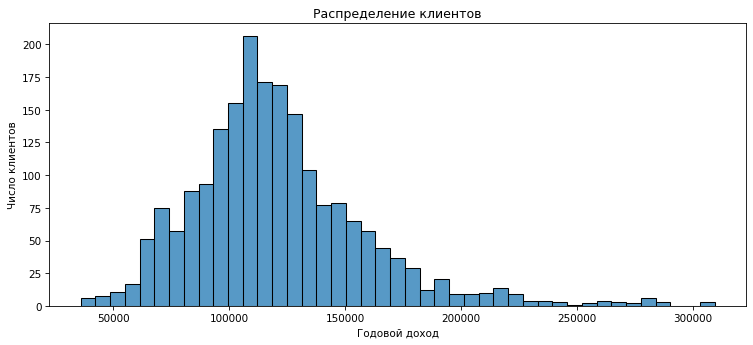

In [247]:
fig = plt.figure(figsize=(12,5), dpi=75)
ax = fig.add_subplot()
ax = sns.histplot(df["Income"])
ax.set_title("Распределение клиентов")
ax.set_xlabel("Годовой доход")
ax.set_ylabel("Число клиентов")
plt.show()

<p>Здесь представлено распределение по годовому доходу, которое тоже формирует нормальное распределение, но не идеальное, что положительно скажется на кластеризации. Основная часть клиентов при этом находится в промежутке от 75 до 150 тыс. долларов в год дохода.</p>

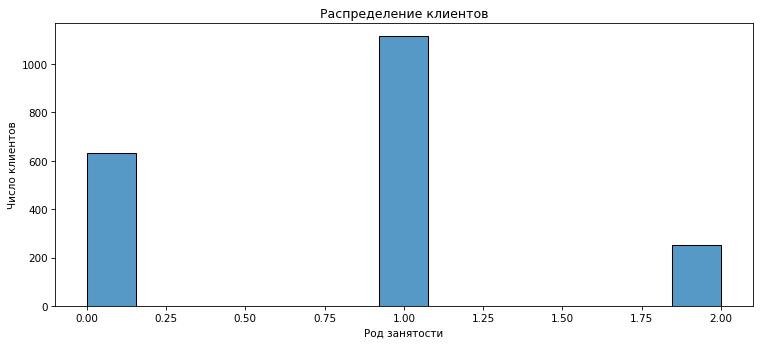

In [248]:
fig = plt.figure(figsize=(12,5), dpi=75)
ax = fig.add_subplot()
ax = sns.histplot(df["Occupation"])
ax.set_title("Распределение клиентов")
ax.set_xlabel("Род занятости")
ax.set_ylabel("Число клиентов")
plt.show()

<p>Здесь представлено распределение по роду деятельности, где 0 – безработный, 1 – квалифицированный работник, 2 – менеджмент, самозанятый или высококвалифицированный работник. Большая часть клиентов являются квалифицированными работниками.
</p>

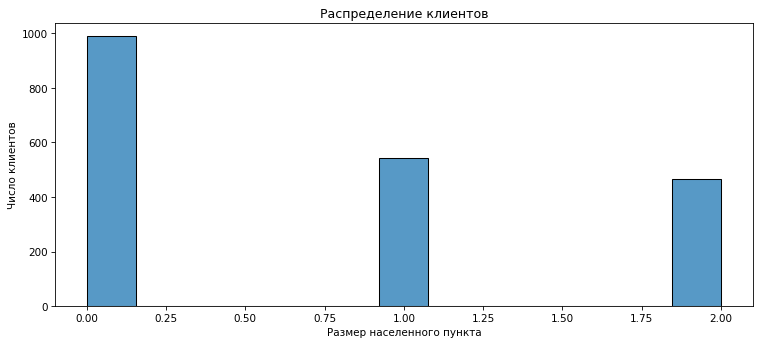

In [249]:
fig = plt.figure(figsize=(12,5), dpi=75)
ax = fig.add_subplot()
ax = sns.histplot(df["Settlement size"])
ax.set_title("Распределение клиентов")
ax.set_xlabel("Размер населенного пункта")
ax.set_ylabel("Число клиентов")
plt.show()

<p>На данном распределении можно увидеть где проживает большая часть клиентов, при этом 0 – маленький город, 1 – среднего размера город, 2 – большой город или мегаполис. Большая часть клиентов проживает в небольших и среднего размера городах. Еще крупная часть проживает в большом городе.
</p>

Для кластеризации используется алгоритм **MeanShift**. <br>
Алгоритм MeanShift состоит из нескольких основных функций: определения bandwidth (радиуса), поиск ближайших соседей, расчет сдвига и формирование кластеров. Возможность выбора числа кластеров для данного алгоритма отсутствует, и он хорошо показывает себя если в данных много кластеров или у них неравномерный размер. Достаточно быстро работает для большого числа признаков. Расчет bandwidth происходит заранее, перед выполнением остальных функций. 

В общем виде шаги алгоритма выглядят следующим образом: 
1.	Произвольно выбирается точка из немаркированных данных в качестве центроида;
2.	Определяем все точки данных являющимися соседями центроида, которые расположены в области с определенным радиусом (bandwidth). Все соседние точки (определенные методом NNS - Nearest neighbor search) считаются принадлежащими одному кластеру. Сохраняем количество посещенных плюс 1 (центроид) и сами точки данных в виде кластера.
3.	Определив центроид и ближайших соседей, создаем вектора, направленные от центра к каждой точке, и складываем их чтобы получить сдвиг вектора.
4.	Новый центр определяется расположением центроида и сдвига. То есть центр смещается в направлении сдвига, а расстояние смещения равно норме вектора сдвига.
5.	Повторяем шаги 2, 3 и 4 до тех пор, пока сдвиг не станет небольшим (схождение), запоминаем новый центр. Во время каждой итерации, точки должны быть отнесены к одному кластеру.
6.	Если расстояние между центром текущего кластера и центрами других существующих кластеров меньше порогового значения при схождении, то кластеры объединяются, и общее число посещенных точек данных, как и сами точки, также объединяется соответственно. В противном случае определяем точки в качестве нового кластера.
7.	Повторяем 1, 2, 3, 4, 5, пока все точки не будут отмечены как посещенные.
8.	Кластеризация: в соответствии с каждым кластером отмечается частота посещения каждой точки, а точка с самой высокой частотой посещения принимается как центр кластера.

<p>Проведем же кластеризацию и проверку разбиения на кластеры.</p>

In [250]:
features_df = [0, 1, 2, 3, 4, 5, 6]
df = customize_data_for_clustering(df, features_df)

meanshift_clusters = meanshift_execute(df, 0, 300)
print("Качество кластеризации по дэвис-болдуину, калински-харабашу и силуэту:\n{0}\n".format(get_quality_clustering(df, meanshift_clusters.labels_)))

Качество кластеризации по дэвис-болдуину, калински-харабашу и силуэту:
(0.4585688713749141, 1521.3316037328636, 0.6532117780588811)



<p>Для проверки кластеризации были взяты три признака - calinski-harabazs, silhouette, davies-bouldin. Метод silhouette - вычисляется с помощью среднего внутрикластерного расстояния и среднего расстояния до ближайшего кластера по каждому образцу. Его результат принимает значения от -1 до 1. <br> Calinski-harabazs - максимальное значение критерия указывает на наиболее вероятное число кластеров (критерий отношения дисперсий). Т.к. в связи с тем, что нет возможности определить число кластеров самостоятельно считаем, что число кластеров адекватное т.к. значение больше 0, достаточно высокое и должно соотвествовать силуэту. <br> Davies-bouldin - его значения находятся в диапазоне от 0 до бесконечности, как и у calinski-harabazs, но полученное значение 0.45 говорит о том, что 2 кластера выделенные алгоритмом выделены адекватно (значение приближенно соотвествует получаемому при 2 кластерах).</p>

<p>Теперь рассмотрим данные по числу элементов в кластерах и их расстояниям, а также о центрах кластеров.</p>

In [251]:
df['Cluster'] = meanshift_clusters.labels_
eucl, manh = get_distance(meanshift_clusters.cluster_centers_, meanshift_clusters.cluster_centers_)

print("Число элементов в кластерах:\n{0}\n".format(df['Cluster'].value_counts()))
print("Кластерные центры:\n{0}\n".format(meanshift_clusters.cluster_centers_))
print("Межкластерное расстояние по евклидову и манхетеннскому:\n{0}\n{1}".format(eucl, manh))
print("\n{0}".format(get_distance_matrix(df.head(4))))

Число элементов в кластерах:
0    1880
1     120
Name: Cluster, dtype: int64

Кластерные центры:
[[5.01335708e-01 5.27159394e-01 3.45022262e+01 1.00979519e+00
  1.13313325e+05 8.02315227e-01 7.08815672e-01]
 [2.17391304e-01 2.17391304e-01 3.96086957e+01 9.56521739e-01
  2.49971652e+05 1.69565217e+00 1.60869565e+00]]

Межкластерное расстояние по евклидову и манхетеннскому:
[[     0.        136658.3272536]
 [136658.3272536      0.       ]]
[[     0.       136665.873824]
 [136665.873824      0.      ]]

[[    0.         26103.03884608 35460.00465313 46895.00518179]
 [26103.03884608     0.         61563.00597762 20792.01279338]
 [35460.00465313 61563.00597762     0.         82355.00010928]
 [46895.00518179 20792.01279338 82355.00010928     0.        ]]


<p>Как видно алгоритм выделил 2 кластера с числом элементов 1880 и 120. Также можно посмотреть центры кластеров и межкластерное расстояние. При этом вычислены парные расстояния и для объектов, в большинстве своем они меньше межкластерного расстояния (расстояние между центроидами), что также соотвествует корректному распределению на кластеры. Для примера привидены расстояния между четырьмя объектами.</p>

<p>Рассмотрим графики между всеми признаками. Как ранее упоминалось, было определено по итогу, при проведении монотетической кластеризации, что большое влияние на кластеризацию вносят признаки Age и Income, рассмотрим их график.</p>

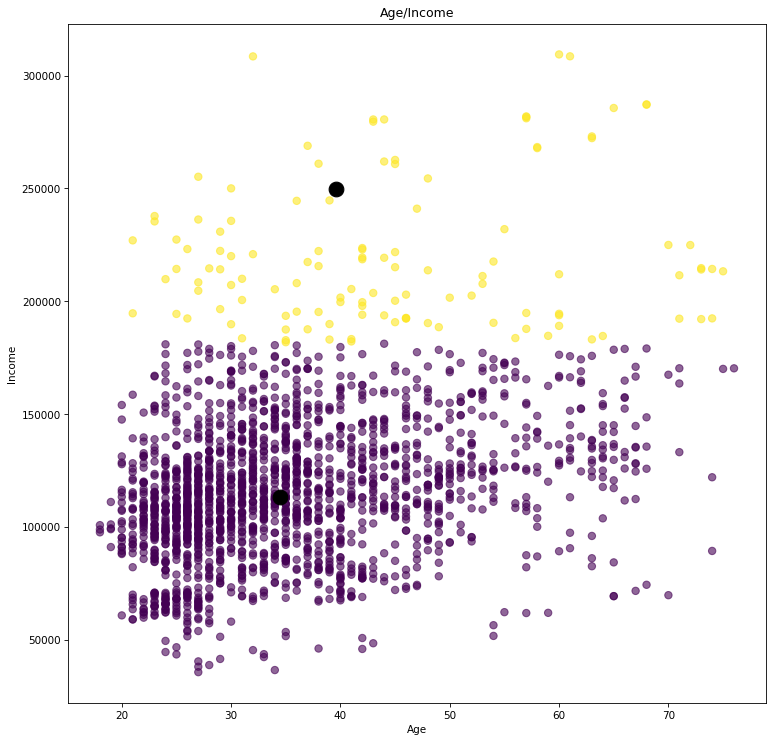

In [252]:
features_2d = [2, 4]
clusters_show(df, features_2d, meanshift_clusters.cluster_centers_, features_df)

<p>Как видно из рисунка 5, наибольшее число клиентов среднего и низкого дохода находится в возрасте от 20 лет до 40, тогда как наиболее богатые в возрасте от 30 до 50. Также стоит отметить, что основная масса людей имеет доход от 50 тысяч и до 150 тысяч долларов в год. При этом получается, что алгоритм выделил 2 кластера, где одни клиенты более богатые, а другие более бедные.</p>

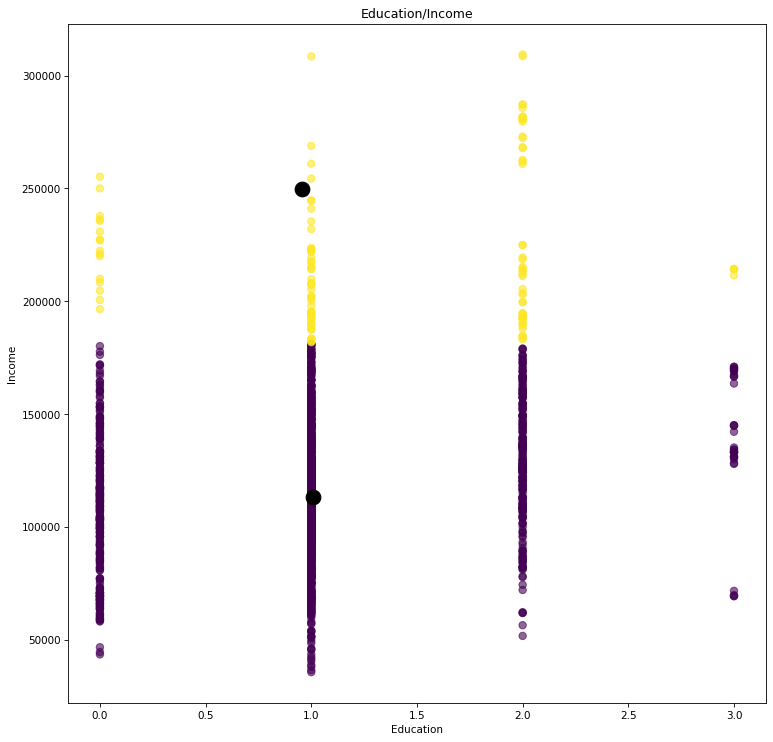

In [253]:
features_2d = [3, 4]
clusters_show(df, features_2d, meanshift_clusters.cluster_centers_, features_df)

<p>Боле существенным признаком является распределение по уровню образования и доходу, здесь была выявлена следующая связь – чем более обеспеченный человек, тем больше его доход, но качественное образование дорого, поэтому чем выше уровень образования, тем меньше людей его получили. При этом как можно увидеть, кроме окончания высшей школы (следующий уровень образования после университета) клиенты со средним достатком и низким, распределены относительно одинаково, а их пик приходится на окончание старшей школы. Возможно, это также стоит учитывать при проведении маркетинговой кампании, ведь чем ниже образование, тем более простую маркетинговую кампанию можно проводить. </p>

<p>В сявзи с тем, что признаки Age и Income оказали большее влияние на кластеризацию, чем другие, они будут использоваться в совместных исследованиях с другими призанками</p>

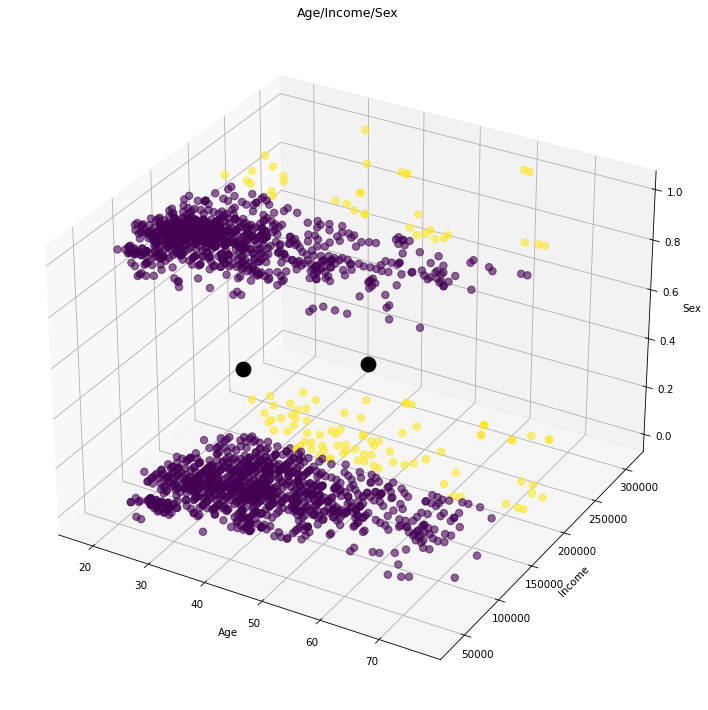

In [254]:
features_3d = [2, 4, 0]
clusters_show3d(df, features_3d, meanshift_clusters.cluster_centers_, features_df) 

В случае учета пола клиентов, для наибольшей группы людей различие не так критично, тогда как для наиболее богатой группы людей становится ясно, что мужчин в данной группе существенно больше, чем женщин. При этом мужчин клиентов в общем ненамного, но больше.

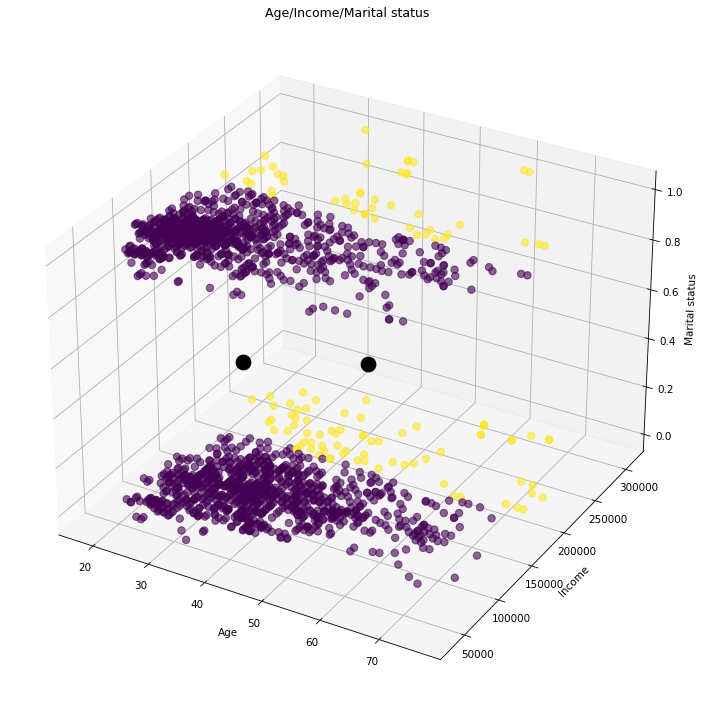

In [255]:
features_3d = [2, 4, 1]
clusters_show3d(df, features_3d, meanshift_clusters.cluster_centers_, features_df)

Далее решено было рассмотреть, насколько сильно влияет семейный статус на распределение клиентов. Как видно, отличий от распределения по семейному статусу существенных нет. Что подтверждается графиком распределения выделенным ранее. Единственное что можно отметить, что холостяков обеспеченых больше, чем семейных людей.

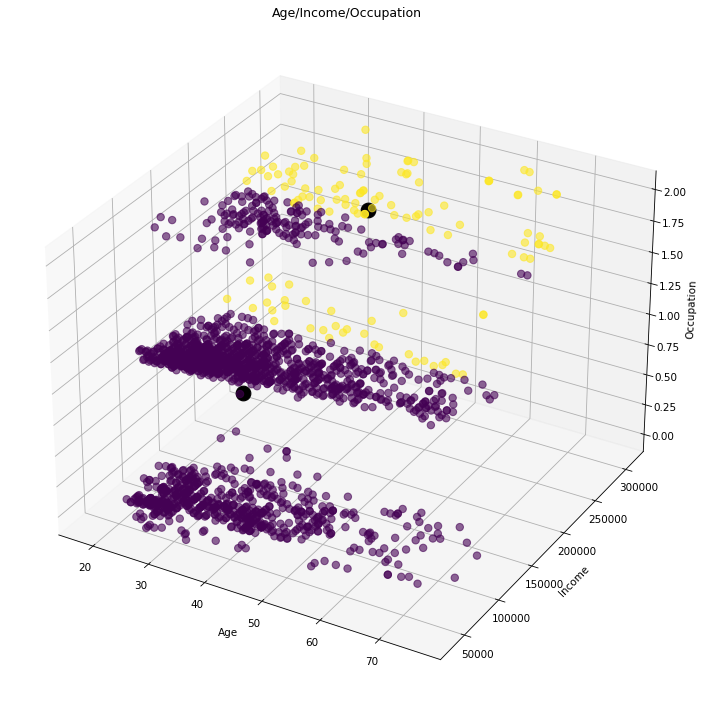

In [256]:
features_3d = [2, 4, 5]
clusters_show3d(df, features_3d, meanshift_clusters.cluster_centers_, features_df)

Следующим было решено рассмотреть то, как влияет занятость на распределение клиентов. Можно выделить следующее – наиболее богатых официально безработных клиентов просто нет. Основная часть клиентов работают и имеют доход примерно от 100 до 300 тысяч долларов в год. Еще небольшая часть людей либо работают неофициально, либо обладают доходом, полученным неизвестными путями, следовательно они могут быть непостоянными клиентами, в том числе из-за проблем с деньгами. Это стоит учитывать при разработке новой линейки одежды.

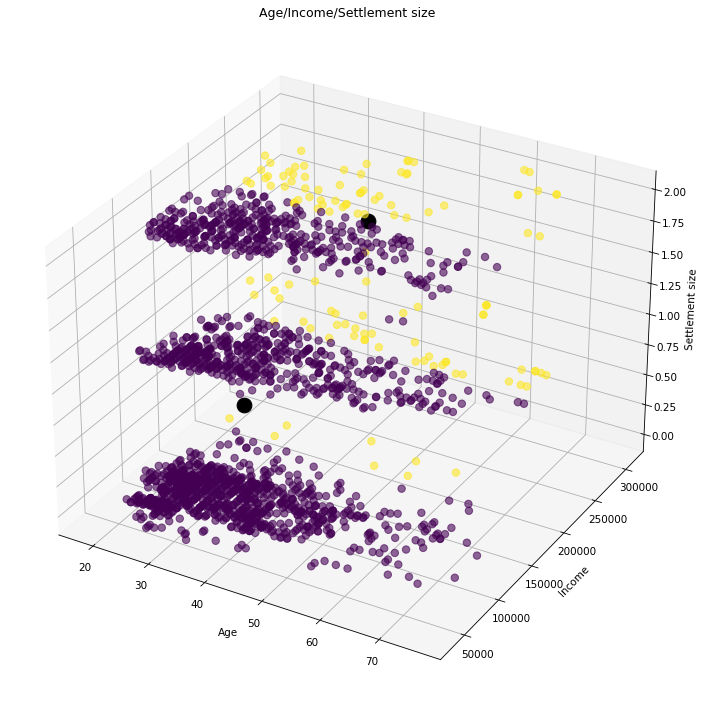

In [257]:
features_3d = [2, 4, 6]
clusters_show3d(df, features_3d, meanshift_clusters.cluster_centers_, features_df)

Последним рассматриваемым фактором стало расположение клиентов в разного размера городах. Здесь также три уровня городов – маленькие, средние и крупные включая мегаполисы. Если выделять людей по этим трем уровням, то больше всего клиентов живет в небольших городах, в том числе там присутствуют и наиболее обеспеченные, но их мало. Если объединить группы из средних и крупных городов, то суммарно их существенно больше. 

Отобразим наглядно распределение кластеров на всех признаках одновременно.

<Figure size 900x900 with 0 Axes>

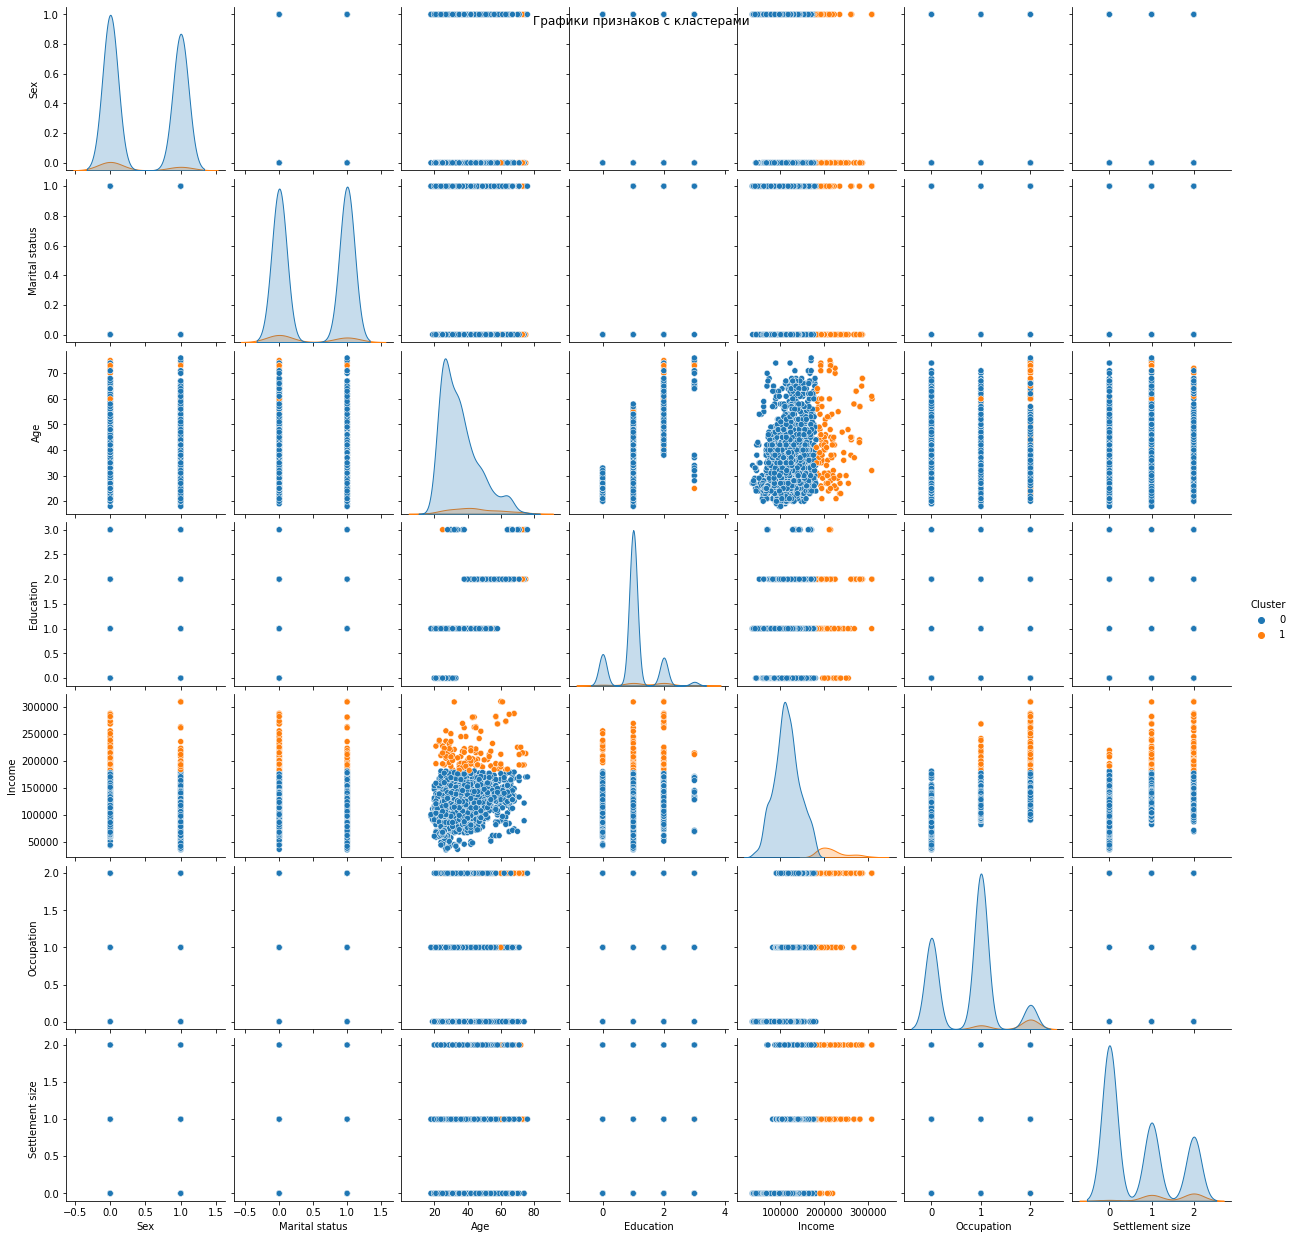

In [258]:
plt.figure(figsize=(12, 12), dpi=75)
sns.pairplot(df, hue='Cluster')
plt.suptitle("Графики признаков с кластерами")
plt.show()

### Основные выводы.
Разработка новой линейки одежды дело затратное - нужны материалы, производственные линии, дизайнеры и многие другие профессионалы своего дела. Хорошим решением перед созданием новой линейки является проведение сегментации клиентов посредством кластеризации. Данный метод позволяет выделить основные группы клиентов, а также понять их распределение относительно других известных о них данных. <br><br>
Для этой работы как раз и была проведена сегментация клиентов и были определены как интересные закономерности, так и распределения клиентов относительно их других особенностей.  Одним из существенных выводов, полученных во время кластеризации, стало то, что при разработке новой линейки одежды необходимо ориентироваться в первую очередь на годовой доход клиента и его возраст. У компании основная часть клиентов находится в диапазоне от 20 до 50 лет, при этом эта часть клиентов фиксируется с годовым доходом от 75 до 200 тысяч долларов, т. е. это достаточно обеспеченные люди, которые могут позволить себе одежду среднего и высокого (не элитного) ценовых сегментов.  Основная масса людей находится в диапазоне от 75 до 150 тысяч долларов. <br><br>
Рекомендуется сделать упор при разработке новой линейки одежды на средний ценовой сегмент, но также добавить несколько дорогих элементов одежды, чтобы для более обеспеченных клиентов также был дополнительный интересный выбор. Дорогие элементы одежды из новой линейки рекомендуется направить в города средней и большой величины, когда как элементы одежды, относящиеся к среднему ценовому сегменту, можно распределить между городами любой величины. Т. к. основная часть клиентов имеет работу то в линейку одежды нужно добавить варианты, подходящие для рабочих условий – рубашки, галстуки и т. д. <br><br>
Маркетинговую кампанию стоит сделать достаточно понятной и прозрачной, ведь большая часть клиентов имеют образование старшей школы и вуза, необходимо использовать обязательные слова об одежде такие как, например – натуральный хлопок и т. д. <br><br>
Распределение по полу практически идентичное, поэтому компании нет необходимости при разработке линейки акцентировать внимание только на какой-то один пол, но это также может привести к удорожанию производства одежды, также распределение по семейному статусу не предполагает какого-либо перекоса – у компании примерно схожие количества людей, как холостых, так и имеющих отношения в каком-либо виде, поэтому в часть линейки относящийся к повседневной носке может добавить несколько варинатов одежды для парного ношения, а также возможно для детей.<br><br>
Как итог можно обозначить то, что компания имеет очень широкий круг клиентов, который охватывает практически все интересы и возможные сочетания, но полезным фактором является то, что возраст и годовой доход — это важнейшие параметры при выборе аудитории, для которой будет изготовлена одежда. Для уменьшения расходов по производству линейки одежды предлагается сконцентрироваться на возрастной категории 20–40  лет и среднем ценовом сегменте, у которых цена одежды будет комфортна при зарплате от 100 до 150 тысяч долларов. Данные диапазоны максимизируют количество людей готовых купить новую одежду. 


## Классификация

Классификация - способ определить класс (тип) объекта на основе его признаков, при этом это метод обучения с учитилем и как итог, данные уже должны иметь классы, чтобы классификатор мог обучиться. 

В нашем случае мы уже имеем данные с определенным классом, где класс это номер кластера, а всего кластеров 2 - где 0 - это менее обеспеченные (бедные) клиенты производителя одежды из США, а 1 - более обеспеченные клиенты (богатые). Попробуем определить к какому классу относятся клиенты и признаки в наибольшей степени влияющие на классификацию.

Для классификации воспользуемся XGBoost, древом решений и логистической классификацией, проверим какой из данных алгоритмов точнее определяет класс нашего нового покупателя.

In [259]:
from xgboost import XGBClassifier
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

df_classifier = df

x_data = df_classifier[["Sex", "Marital status", "Age", "Education", "Income", "Occupation", "Settlement size"]]
y_data = df_classifier["Cluster"]

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2)

Средняя абсолютная погрешность (mae): 0.0525
Оценочная точность: 0.9475
Исходные классы:
[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0

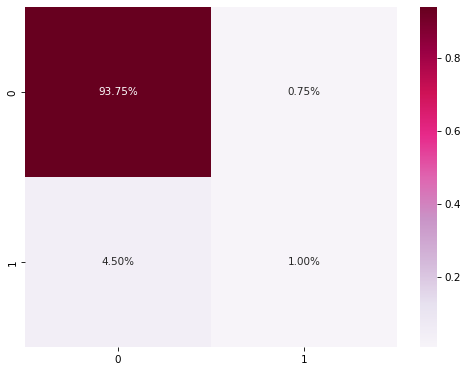

In [260]:
clf_lr = LogisticRegression().fit(x_train, y_train)
y_pred = clf_lr.predict(x_test)

print("Средняя абсолютная погрешность (mae): {0}".format(mean_absolute_error(y_test, y_pred)))
print("Оценочная точность: {0}".format(accuracy_score(y_test, y_pred)))

print("Исходные классы:\n{0}".format(y_test.to_list()))
print("Предсказанные классы:\n{0}".format(y_pred))

cm = confusion_matrix(y_test, y_pred)
fig = plt.figure(figsize=(8,6), dpi=75)
ax = fig.add_subplot()
ax = sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap="PuRd")
plt.show()

Средняя абсолютная погрешность (mae): 0.0
Оценочная точность: 1.0
Исходные классы:
[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0

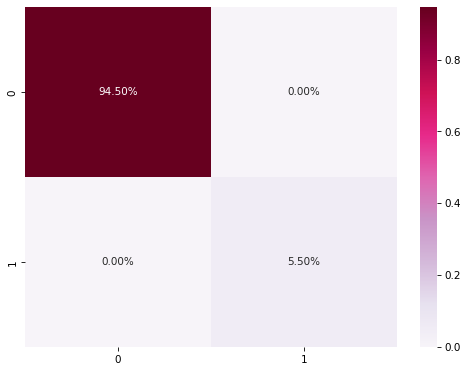

In [261]:
clf_xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss').fit(x_train, y_train)
y_pred = clf_xgb.predict(x_test)

print("Средняя абсолютная погрешность (mae): {0}".format(mean_absolute_error(y_test, y_pred)))
print("Оценочная точность: {0}".format(accuracy_score(y_test, y_pred)))

print("Исходные классы:\n{0}".format(y_test.to_list()))
print("Предсказанные классы:\n{0}".format(y_pred))

cm = confusion_matrix(y_test, y_pred)
fig = plt.figure(figsize=(8,6), dpi=75)
ax = fig.add_subplot()
ax = sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap="PuRd")
plt.show()

Средняя абсолютная погрешность (mae): 0.0
Оценочная точность: 1.0
Исходные классы:
[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0

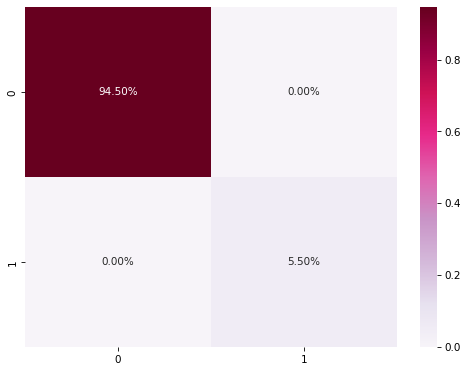

In [262]:
clf_dtc = tree.DecisionTreeClassifier().fit(x_train, y_train)
y_pred = clf_dtc.predict(x_test)

print("Средняя абсолютная погрешность (mae): {0}".format(mean_absolute_error(y_test, y_pred)))
print("Оценочная точность: {0}".format(accuracy_score(y_test, y_pred)))

print("Исходные классы:\n{0}".format(y_test.to_list()))
print("Предсказанные классы:\n{0}".format(y_pred))

cm = confusion_matrix(y_test, y_pred)
fig = plt.figure(figsize=(8,6), dpi=75)
ax = fig.add_subplot()
ax = sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap="PuRd")
plt.show()


Как видно из результатов классификации хуже всего себя представляет логистическая регрессия, т.к. это самый простой (классический) алгоритм классификации. Но по причине того, что от того более обеспеченный или менее обеспеченный клиент, зависит прибыль компании и затраты на производство одежды, стоит использовать наиболее мощные средства, в данном случае идеально подойдут XGBoost или Decision Tree (древо принятия решений).

Теперь определим - какие признаки вносят наибольшее влияние на предсказание класса клиента, по данным XGBoost и Decision Tree.

In [263]:
print(clf_dtc.feature_names_in_)
print(clf_lr.coef_)
print(clf_dtc.feature_importances_)
print(clf_xgb.feature_importances_)

['Sex' 'Marital status' 'Age' 'Education' 'Income' 'Occupation'
 'Settlement size']
[[-4.34568208e-03 -4.04283627e-03 -1.66290994e-01 -4.14231265e-03
   2.37327075e-05  2.46278420e-03  1.58509965e-03]]
[0. 0. 0. 0. 1. 0. 0.]
[0. 0. 0. 0. 1. 0. 0.]


Как видно выше, наиболее весомым признаком классификации по XGBoost и Decision Tree является - Income или годовой доход. Данный признак был определен наиболее важным еще на этапе кластеризации. Но на этапе кластеризации важным признаком еще являлся и возраст клиента, возможно что для данных алгоритмов он является менее важным. При этом для логистической кластеризации все признаки являются важными, отличается только их влияние.

In [264]:
print("Данные для первых 8 клиентов, берем под номером 7:\n{0}".format(df.head(8)))

predict_data = df[["Sex", "Marital status", "Age", "Education", "Income", "Occupation", "Settlement size"]] 
predict_data = predict_data.iloc[[7]]

print("Данные клиента:\n{0}".format(predict_data))
pred_cluster = meanshift_clusters.predict(predict_data)

Данные для первых 8 клиентов, берем под номером 7:
   Sex  Marital status  Age  Education  Income  Occupation  Settlement size  \
0    0               0   67          2  124670           1                2   
1    1               1   22          1  150773           1                2   
2    0               0   49          1   89210           0                0   
3    0               0   45          1  171565           1                1   
4    0               0   53          1  149031           1                1   
5    0               0   35          1  144848           0                0   
6    0               0   53          1  156495           1                1   
7    0               0   35          1  193621           2                1   

   Cluster  
0        0  
1        0  
2        0  
3        0  
4        0  
5        0  
6        0  
7        1  
Данные клиента:
   Sex  Marital status  Age  Education  Income  Occupation  Settlement size
7    0               0   35 

C:\Python310\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MeanShift was fitted without feature names
  warnings.warn(


In [265]:
print("Кластер клиента:\n{0}".format(pred_cluster))
print("Класс клиента по логистической регрессии:\n{0}".format(clf_lr.predict(predict_data)))
print("Класс клиента по Decision Tree:\n{0}".format(clf_dtc.predict(predict_data)))
print("Класс клиента XGB:\n{0}".format(clf_xgb.predict(predict_data)))

Кластер клиента:
[1]
Класс клиента по логистической регрессии:
[0]
Класс клиента по Decision Tree:
[1]
Класс клиента XGB:
[1]


### Основные выводы

Как видно по итогу предсказания класса клиента - алгоритмы классификации Decision Tree и XGBoost определелили его в кластер под номером 1, как и алгоритм MeanShift отнес данного клиента к кластеру номер 1, при этом логистическая регрессия определила класс неправильно.
По мнению классификаторов Decision Tree и XGBoost важным признаком является только Income, но по факту проведения кластеризации должен быть еще и Age.

## Регрессия

Для компании производителя одежды из США важной задачей является возможность определения возраста покупателя, потому что благодаря этому можно будет прогнозировать на основе данных клиентов, например из маленького города, под какую возрастную категорию должна быть одежда. Воспользуемся для этой задачи линейной регрессией. Т.к. данные используемые для кластеризации, уже имеют кодирования и достаточно малы, а возраст и годовой доход величины достаточно реальны и сложно их считать выбросами, то качество модели на подобных реальных данных может быть достаточно низкое, но если качество модели будет выше 0.5, в случае реальных данных, даже подобную модель можно использовать для минимального прогнозирования, что уже увеличит возможности нашего заказчика по получению прибыли. 

      Sex  Marital status  Age  Education  Income  Occupation  Settlement size
0       0               0   67          2  124670           1                2
1       1               1   22          1  150773           1                2
2       0               0   49          1   89210           0                0
3       0               0   45          1  171565           1                1
4       0               0   53          1  149031           1                1
...   ...             ...  ...        ...     ...         ...              ...
1995    1               0   47          1  123525           0                0
1996    1               1   27          1  117744           1                0
1997    0               0   31          0   86400           0                0
1998    1               1   24          1   97968           0                0
1999    0               0   25          0   68416           0                0

[2000 rows x 7 columns]
Коэфициенты: 
 [-3.35790810

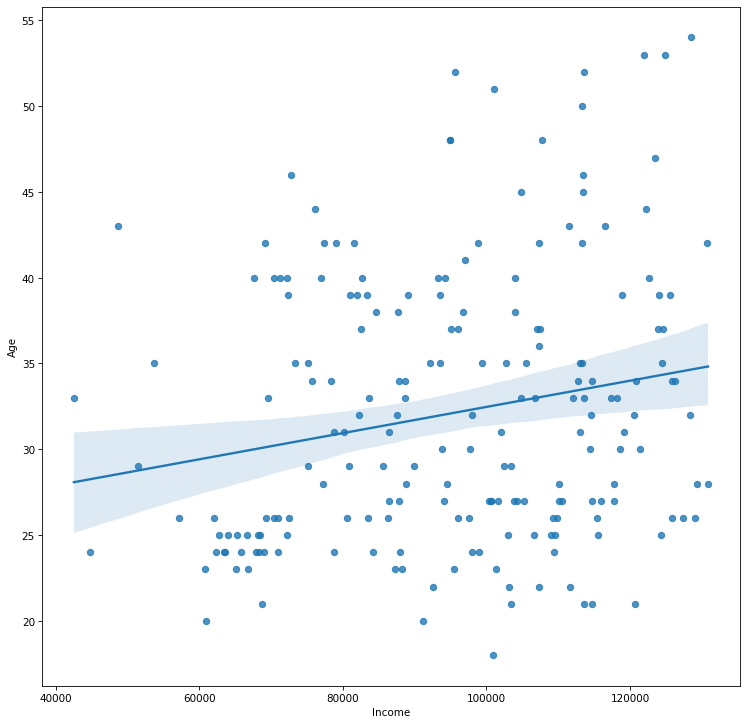

In [266]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split


df_lin = df[["Sex", "Marital status", "Age", "Education", "Income", "Occupation", "Settlement size"]]

print(df_lin)

x_data = df_lin[["Sex", "Marital status", "Education", "Income", "Occupation", "Settlement size"]]
y_data = df_lin["Age"]

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.1, shuffle=False)


regr = linear_model.LinearRegression()

regr.fit(x_train, y_train)

y_pred = regr.predict(x_test)

print("Коэфициенты: \n", regr.coef_)
print("Среднеквадратичная ошибка: {0}".format(round(mean_squared_error(y_test, y_pred), 2)))
print("Коэфициент детерминации: {0}".format(round(r2_score(y_test, y_pred), 2)))


fig = plt.figure(figsize=(12, 12), dpi=75)
ax = fig.add_subplot()
ax = sns.regplot(x=x_test["Income"], y=y_test)
plt.show()

Для определения качества модели были вычислены срденнеквадратичная ошибка и коэфициент детерминации. Среднеквадратичная ошибка в зависимости от используемых данных дает результат от 30.23 до 47, т.к. чем меньшее значение будет в итоге тем лучше, было решено остановиться на значении 30.23. Основным способ определения адекватности модели является также коэфициент детерминации, в данном случае он выше 0.52, что на реальных данных достаточно хороший результат и как следствие данную модель уже можно использовать для прогнозирования.

Посмотрим распределение предсказанного линейной регрессией возраста, график ниже.

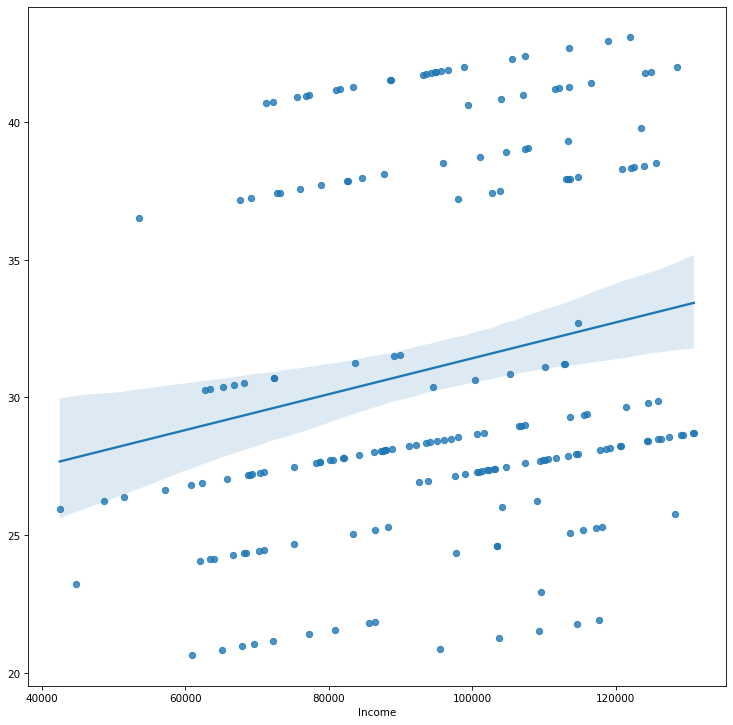

In [267]:
fig = plt.figure(figsize=(12, 12), dpi=75)
ax = fig.add_subplot()
ax = sns.regplot(x=x_test["Income"], y=y_pred)
plt.show()

Как видно из линии тренда, на графике с предсказанным возрастом и изначальным - чем выше возраст, тем выше доход. Следовательно в города где больше обеспеченных людей, необходимо везти одежду для более старших по возрасту клиентов. А полученная модель на основе данных клиентов в каком-либо городе позволит предсказать возраст на который необходимо ориентироваться как при доставке, так и при производстве одежды.

Для проверки также обратим внимание на распределение остатков, чтобы быть более уверенными в качестве регрессионной модели.

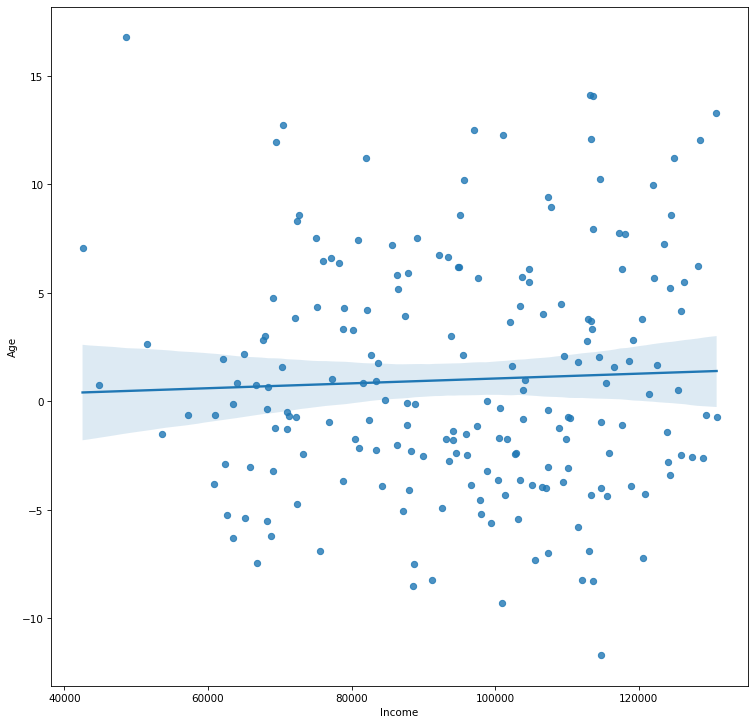

In [268]:
difference = y_test - y_pred

fig = plt.figure(figsize=(12, 12), dpi=75)
ax = fig.add_subplot()
ax = sns.regplot(x=x_test["Income"], y=difference)
plt.show()


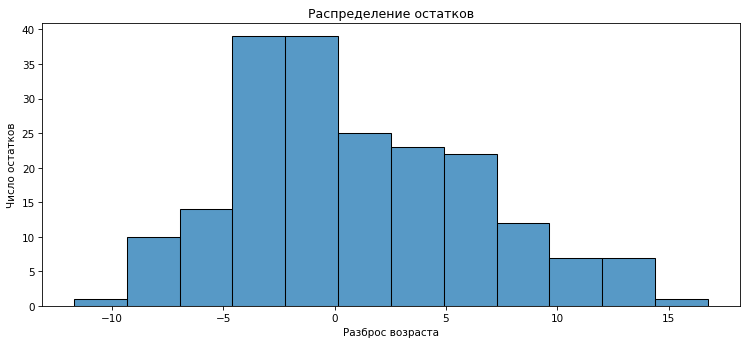

In [269]:
fig = plt.figure(figsize=(12,5), dpi=75)
ax = fig.add_subplot()
ax = sns.histplot(difference)
ax.set_title("Распределение остатков")
ax.set_xlabel("Разброс возраста")
ax.set_ylabel("Число остатков")
plt.show()

Как видно по данным выше, еще одна проверка, а именно остатков дает понять, что регрессионная модель построена адекватно - распределение почти нормальное, остатки на графике расположены адекватно (а точнее это можно увидеть по линии тренда).

Также можно посмотреть на дополнительные запуски с различными выборками из данных. Как видно ниже они дает лучшие результаты по коэфициенту детерминации, но это связано с выбросами, если обратить внимание на графики. Коэфициент детерминации очень чувствителен для выбросов. При этои как видно средневкадратичная ошибка выше, что является плохим показателем по сравнению с предыдущей моделью.

Коэфициенты: 
 [-2.95323665e+00 -1.02547239e+01  1.58409155e+01  4.66768574e-05
 -1.41262090e+00 -3.37245765e-01]
Среднеквадратичная ошибка: 36.51
Коэфициент детерминации: 0.76


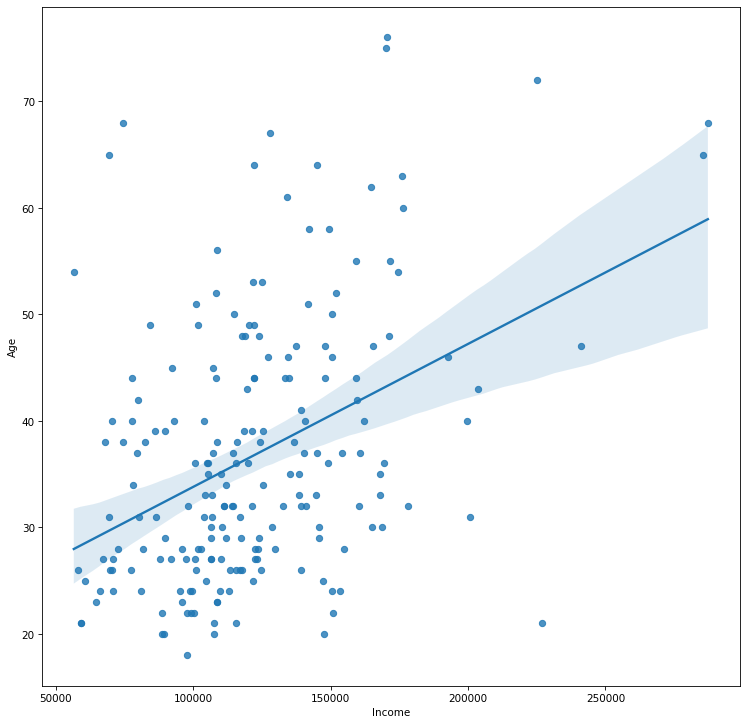

In [270]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.1, shuffle=True)


regr = linear_model.LinearRegression()

regr.fit(x_train, y_train)

y_pred = regr.predict(x_test)

print("Коэфициенты: \n", regr.coef_)
print("Среднеквадратичная ошибка: {0}".format(round(mean_squared_error(y_test, y_pred), 2)))
print("Коэфициент детерминации: {0}".format(round(r2_score(y_test, y_pred), 2)))

fig = plt.figure(figsize=(12, 12), dpi=75)
ax = fig.add_subplot()
ax = sns.regplot(x=x_test["Income"], y=y_test)
plt.show()

Коэфициенты: 
 [-2.79643120e+00 -1.02473936e+01  1.59613587e+01  4.64757416e-05
 -1.49241879e+00 -2.50211674e-01]
Среднеквадратичная ошибка: 40.66
Коэфициент детерминации: 0.73


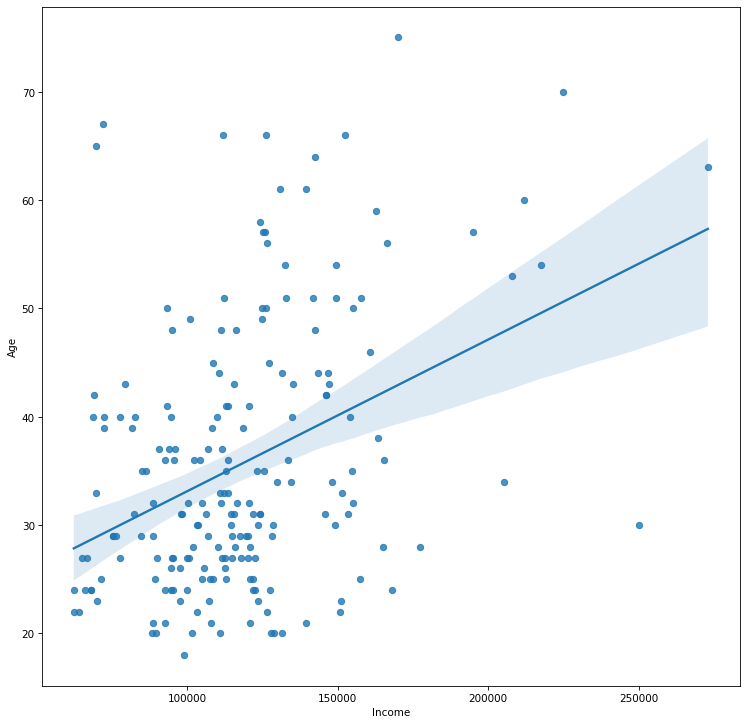

In [271]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.1, shuffle=True)


regr = linear_model.LinearRegression()

regr.fit(x_train, y_train)

y_pred = regr.predict(x_test)

print("Коэфициенты: \n", regr.coef_)
print("Среднеквадратичная ошибка: {0}".format(round(mean_squared_error(y_test, y_pred), 2)))
print("Коэфициент детерминации: {0}".format(round(r2_score(y_test, y_pred), 2)))

fig = plt.figure(figsize=(12, 12), dpi=75)
ax = fig.add_subplot()
ax = sns.regplot(x=x_test["Income"], y=y_test)
plt.show()

### Основные выводы

Как итог можно отметить, что теперь у компании производителя одежды из США с собственными магазинами, есть возможность прогнозирования возраста клиента и следовательно, например в одни города можно привозить больше одежды для одного возраста (более старшего как пример) и меньше для других возрастных категорий, тем самым увеличивая выручку и прибыль компании. Или, например, на основе дохода определять возраст клиента, что также позволит предполагать какую одежду необходимо привезти в магазин или разработать. 